<a href="https://colab.research.google.com/github/Flociah/git_practice/blob/main/More_on_Missing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More on Missing Data

## Introduction

While imputing the medan or median are standard methods of dealing with missing values, these standard methods do have caveats. For example, doing so will reduce the overall variance of your dataset which should be taken into account when performing subsequent analyses or training a machine learning algorithm on the dataset.

## Objectives

You will be able to:

- Evaluate and execute the best strategy for dealing with missing, duplicate, and erroneous values for a given dataset   
- Determine how the distribution of data is affected by imputing values   
- Inspect data for duplicates or extraneous values and remove them

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('titanic.csv')
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


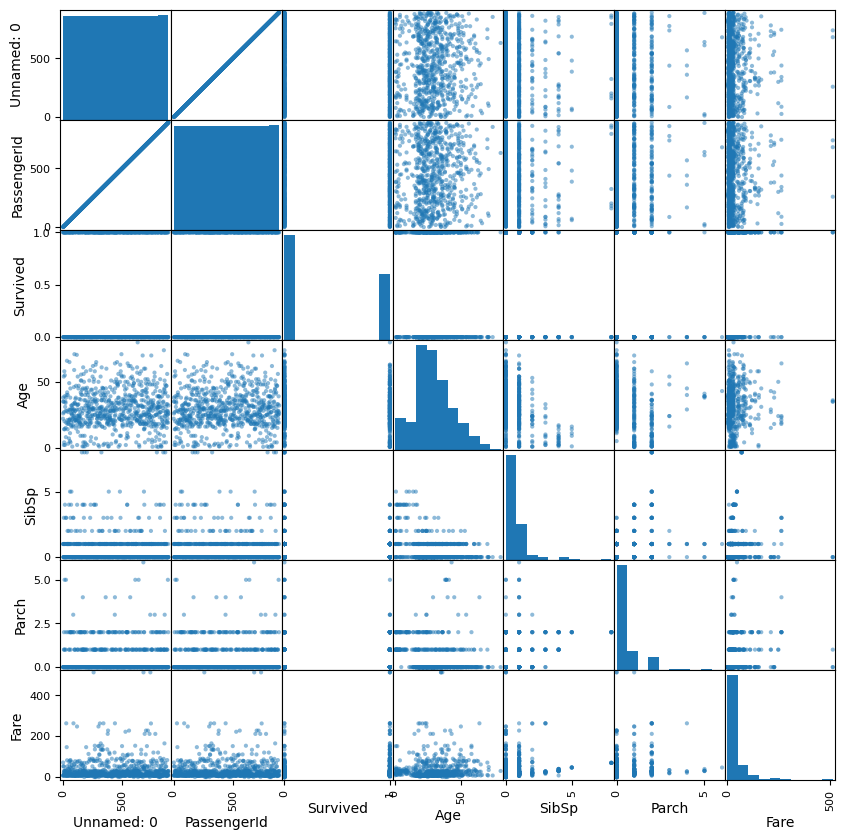

In [3]:
pd.plotting.scatter_matrix(df, figsize=(10,10));

## Check for missing data

Typically, the first step in checking for missing data is to simply use the `.info()` method. This gives us various information about the columns including their data type and the number of non-missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    object 
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


As you can see, `'Age'` and `'Cabin'` have a substantial amount of missing values, and `'Embarked'` has two extraneous missing values.

## Check for duplicates

While `df.info()` is a good initial spot check for missing values, it may not catch more subtle anomalies in the data such as duplicates. While these values are populated, it is always worrisome if we have observation rows with identical data.

In [5]:
duplicates = df[df.duplicated()]
print(len(duplicates))
duplicates.head()

0


,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Similarly, if a feature such as `'PassengerId'` can be assumed to be unique, we can further check if there are duplicate rows based on a subset of the DataFrame columns.

In [6]:
duplicates = df[df.duplicated(subset='PassengerId')]
print(len(duplicates))
duplicates.tail()

0


,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


## Check for extraneous values

Sometimes, missing values are even further hidden within a dataset. For example, sometimes an entry such as `999999` is used for missing values, or an arbitrary date such as `12-01-1970` might be set for unknown dates. In general, doing a quick eyeball and previewing the top occurring values for each feature can help further tease out peculiarities in the dataset.

In [7]:
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n')

Unnamed: 0 
 Unnamed: 0
0      0.001122
598    0.001122
587    0.001122
588    0.001122
589    0.001122
Name: proportion, dtype: float64 


PassengerId 
 PassengerId
1      0.001122
599    0.001122
588    0.001122
589    0.001122
590    0.001122
Name: proportion, dtype: float64 


Survived 
 Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64 


Pclass 
 Pclass
3    0.526375
1    0.225589
2    0.193042
?    0.054994
Name: proportion, dtype: float64 


Name 
 Name
Braund, Mr. Owen Harris             0.001122
Boulos, Mr. Hanna                   0.001122
Frolicher-Stehli, Mr. Maxmillian    0.001122
Gilinski, Mr. Eliezer               0.001122
Murdlin, Mr. Joseph                 0.001122
Name: proportion, dtype: float64 


Sex 
 Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64 


Age 
 Age
24.0    0.042017
22.0    0.037815
18.0    0.036415
19.0    0.035014
28.0    0.035014
Name: proportion, dtype: float64 


SibSp 
 SibSp
0    0.682379
1    0.234

You can see that we've uncovered another case of missing data that did not show up before. The `'Pclass'` feature has `?` for roughly 10% of the entries.

## Choosing a methodology

How do you choose which method for dealing with missing data to use? The answer will depend on the scenario and specifics to the application itself. As a general rule of thumb, we tend towards imputing values rather than dropping them, as we wish to use as much information as possible. That said, larger gaps where data is missing can pose more substantial problems, and thereby warrant alternative approaches. We'll take a look at specific cases below in more detail, but here's a quick table of your options.

|         | Continuous          | Categorical  |
| ------------- |:-------------:| -----:|
| Delete      | Delete rows (observations) <br> Delete column (entire variable)| Delete rows (observations) <br> Delete column (entire variable)|
| Replace | replace using median/mean | replace using mode
| Keep | keep as NA (not possible for many ML algorithms) | NA category

## Imputing values

Imputing values is often a go to option when dealing with missing data. For example, if we are building a machine learning model with the data, many algorithms cannot handle missing values. By imputing data, we still get to use the full extent of the data at hand without having to throw away data, which, as you know, is an easy option.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Survived     891 non-null    int64  
 3   Pclass       891 non-null    object 
 4   Name         891 non-null    object 
 5   Sex          891 non-null    object 
 6   Age          714 non-null    float64
 7   SibSp        891 non-null    int64  
 8   Parch        891 non-null    int64  
 9   Ticket       891 non-null    object 
 10  Fare         891 non-null    float64
 11  Cabin        204 non-null    object 
 12  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


## Considerations when imputing

When imputing missing values, keep in mind that you are influencing the distribution of this variable. For example, if you impute the mean, you will reduce the variance of that feature.

## When to drop rows


Dropping rows is an appropriate choice if there are very few missing values to start with. After all, we do not wish to throw away troves of data if we have it, so cases in which there are larger occurrences of missing values, dropping all occurrences is typically inadvisable.

## When to drop columns

Dropping columns is typically a last case resort. That said, if a feature does not add predictive value to the machine learning algorithm driving your application, dropping said feature has no cost.

A few simple lines such as this can easily subset your DataFrame:  
~~~
cols_to_remove = ['col1', 'col2']
cols = [col for col in df.columns if col not in cols_to_remove]
subset = df[cols]
~~~

## Summary

In this lesson, we took a look at methods for identifying duplicate data as well as missing data that is not null, but filled with a placeholder value (such as `?`).